In [1]:
import scipy
import scipy.io as sio
import scipy.fftpack
import scipy.signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

## Functions

In [2]:
def plot_time_comparison(seegprep_signal, fieldtrip_signal, srate, titles, seconds=60):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))

    time = np.arange(0,len(seegprep_signal))/srate

    axs[0].plot(time[0:srate*seconds], seegprep_signal[0:srate*seconds], linewidth=0.1)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude ($\mu$V)')
    axs[0].set_title(titles[0])

    axs[1].plot(time[0:srate*seconds], fieldtrip_signal[0:srate*seconds], linewidth=0.1)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Amplitude ($\mu$V)')
    axs[1].set_title(titles[1])

    plt.tight_layout()

In [3]:
def plot_freq_comp(seegprep_signal, fieldtrip_signal, titles, srate):
    # Freq domain response
    length_segment = 3.0
    f_seegpre, welchpow_seegprep = welch(seegprep_signal, fs=srate, nperseg=int(length_segment*srate))
    f_ft, welchpow_ft = welch(fieldtrip_signal, fs=srate, nperseg=int(length_segment*srate))

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))

    # Plot until 200 hz
    if srate > 200:
        f_max = f_ft.tolist().index(200)
    else:
        f_max = len(f_ft)
        
    axs[0].plot(f_seegpre[0:f_max], welchpow_seegprep[0:f_max], linewidth=0.8)
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_ylabel('Amplitude ($\mu$V$^2$/Hz)')
    axs[0].set_title(titles[0])

    axs[1].plot(f_ft[0:f_max], welchpow_ft[0:f_max], linewidth=0.8)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Amplitude ($\mu$V$^2$/Hz)')
    axs[1].set_title(titles[1])

    plt.tight_layout()


In [4]:
def plot_stft_comp(seegprep_signal, fieldtrip_signal, srate, nperseg, titles, seconds=60):
    f_s, t_s, Zxx_seegprep = scipy.signal.stft(seegprep_signal[0:seconds*srate], fs=srate, nperseg=nperseg)
    f_ft, t_ft, Zxx_ft = scipy.signal.stft(fieldtrip_signal[0:seconds*srate], fs=srate, nperseg=nperseg)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))

    # Plot between 50 and 70 Hz
    f_max = np.argmin(np.abs(f_ft-70))
    f_min = np.argmin(np.abs(f_ft-50))
    
    vmin=min(np.min(np.abs(Zxx_seegprep[f_min:f_max,:])), np.min(np.abs(Zxx_ft[f_min:f_max,:])))
    vmax=min(np.max(np.abs(Zxx_seegprep[f_min:f_max,:])), np.max(np.abs(Zxx_ft[f_min:f_max,:])))
        
    c = axs[0].pcolormesh(t_s, f_s[f_min:f_max], np.abs(Zxx_seegprep)[f_min:f_max,:], vmin=vmin, vmax=vmax)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Frequency (Hz)')
    axs[0].set_title(titles[0])
    plt.colorbar(c, ax=axs[0], label='Amplitude ($\mu$V)')

    c = axs[1].pcolormesh(t_ft, f_ft[f_min:f_max], np.abs(Zxx_ft)[f_min:f_max,:], vmin=vmin, vmax=vmax)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Frequency (Hz)')
    axs[1].set_title(titles[1])
    plt.colorbar(c, ax=axs[1], label='Amplitude ($\mu$V)') 

    plt.tight_layout()

## Test synthetic signal

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

# Parameters
fs = 400  # Sampling rate
duration = 120  # seconds
t = np.arange(0, duration, 1/fs)
n = len(t)

# Generate pink noise (1/f noise)
import numpy as np
import scipy.signal
n = duration*fs; #2-min sequence
n_chns = 100
randn = np.random.randn(n, n_chns)
s = scipy.signal.lfilter([1],[1,-0.9],100*randn, axis=0); #1/f PSD
eeg_signal = s

# Define power line noise frequencies
line_freqs = [60, 120, 180]

# Amplitude of noise
amplitude_noise = 40

# Function to add sinusoidal noise
def add_line_noise(signal, line_freq, noise_modulation, amplitude=1.0):
    return signal + (amplitude * np.sin(2 * np.pi * line_freq * t)).reshape(-1,1) * noise_modulation

# Scenario A: EEG with sharp peaks
eeg_signal_a = eeg_signal.copy()
noise_modulation = np.random.rand(eeg_signal_a.shape[-1])+0.5
for lf in line_freqs:
    eeg_signal_a = add_line_noise(eeg_signal_a, lf, noise_modulation, amplitude_noise)
    amplitude_noise = amplitude_noise*0.75

# Scenario B: Line noise with more broadband noise
eeg_signal_b = eeg_signal.copy()
freqs = np.fft.rfftfreq(n, 1/fs)
def create_exponential_decay_shape(freqs, line_freq, width=10, decay_rate=1):
    """Create an exponential decay shape in the frequency domain centered at line_freq."""
    # Determine the indices for the exponential shape
    indices = np.where((freqs >= line_freq - width) & (freqs <= line_freq + width))[0]
    # Initialize the shape with zeros
    exp_shape = np.zeros_like(freqs)

    # Construct the exponential decay shape
    for idx in indices:
        # Calculate the distance from the center frequency
        distance = abs(freqs[idx] - line_freq)
        # Apply exponential decay based on the distance
        exp_shape[idx] = np.exp(-decay_rate * distance)

    # Normalize to have the same peak height as the line frequency component
    peak_height = np.exp(-decay_rate * np.min(np.abs(freqs[indices] - line_freq)))
    exp_shape = exp_shape / peak_height

    return exp_shape

# Apply the exponential decay noise function in Scenario B
width = 1 # Controls the initial spread of the exponential decay
decay_rate = 0.9  # Controls how quickly the noise decays; adjust as needed
# Mean amplitude of noise
amplitude_noise = 15*10**4

for lf in line_freqs:
    exp_decay_noise = create_exponential_decay_shape(freqs, lf, width=width, decay_rate=decay_rate)
    # Apply the exponential decay noise in the frequency domain
    eeg_signal_b += (amplitude_noise*np.fft.irfft(exp_decay_noise * np.random.normal(size=len(freqs)), n)).reshape(-1,1)*noise_modulation
    amplitude_noise *= 0.75

In [11]:
np.argmax(noise_modulation)

90

In [ ]:
scipy.io.savemat('PLI_test_signals.mat', {'eeg_signal_a': eeg_signal_a, 
                                          'eeg_signal_b': eeg_signal_b,
                                          'noisy_signal': eeg_signal,
                                         'clean_signal': s})

In [19]:
mat_contents = sio.loadmat('PLI_test_signals.mat')
eeg_signal_a = mat_contents['eeg_signal_a']
eeg_signal_b = mat_contents['eeg_signal_b']
eeg_signal = mat_contents['noisy_signal']
s = mat_contents['clean_signal']
eeg_signal_a.shape, eeg_signal_b.shape, eeg_signal.shape, s.shape

((48000, 100), (48000, 100), (48000, 100), (48000, 100))

93


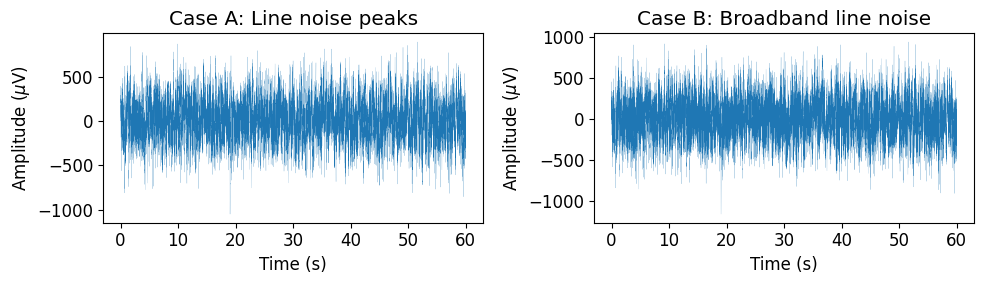

In [30]:
import matplotlib
font = {'size'   : 12}
matplotlib.rc('font', **font)
signal_idx = 93#np.random.randint(0, eeg_signal_a.shape[-1])
print(signal_idx)
plot_time_comparison(eeg_signal_a[:,signal_idx], eeg_signal_b[:,signal_idx], 500, titles=['Case A: Line noise peaks', 'Case B: Broadband line noise'], seconds=60)

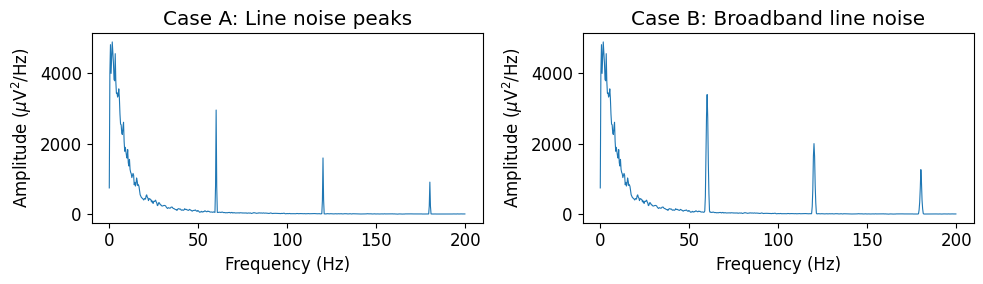

In [31]:
plot_freq_comp(eeg_signal_a[:,signal_idx], eeg_signal_b[:,signal_idx], titles=['Case A: Line noise peaks', 'Case B: Broadband line noise'], srate=400)

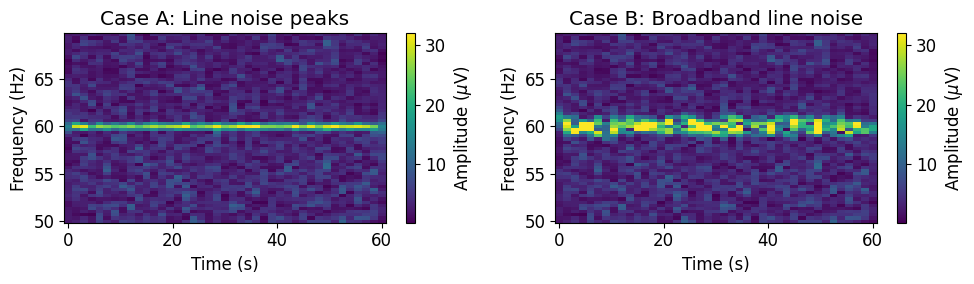

In [32]:
plot_stft_comp(eeg_signal_a[:,signal_idx], eeg_signal_b[:,signal_idx], 400, 3*400, titles=['Case A: Line noise peaks', 'Case B: Broadband line noise'], seconds=60)

## Cleaning

In [40]:
import sys
sys.path.append('../')
from clean_seeg.clean_seeg.clean_PLI import removePLI, zapline, cleanline, removePLI_chns

### Case A

In [5]:
fs = 400
print('a]')


a]


In [6]:
y2 = cleanline(eeg_signal_a, fs, bandwidth=8, maximumIterations=10) # Default in app

/scratch/mcesped/code/sEEGPrep/notebooks/../clean_seeg/clean_seeg/utils.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  datafit[indx, :] = datafitwin
/scratch/mcesped/code/sEEGPrep/notebooks/../clean_seeg/clean_seeg/utils.py:848: ComplexWarning: Casting complex values to real discards the imaginary part
  datafitwin[0:Noverlap, :] = np.multiply(
/scratch/mcesped/code/sEEGPrep/notebooks/../clean_seeg/clean_seeg/utils.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  datafit[indx, :] = datafitwin
/scratch/mcesped/code/sEEGPrep/notebooks/../clean_seeg/clean_seeg/utils.py:848: ComplexWarning: Casting complex values to real discards the imaginary part
  datafitwin[0:Noverlap, :] = np.multiply(
/scratch/mcesped/code/sEEGPrep/notebooks/../clean_seeg/clean_seeg/utils.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  datafit[indx, :] = datafitwin
/scratch/mcesped/code/sEEGPrep/notebooks/..

In [6]:
y2.shape

(48000, 100)

In [7]:
fs=400
y1 = zapline(eeg_signal_a, 60/fs, fs)

In [5]:
y1

array([[ -61.10425793,  188.27216584],
       [-140.87845143,  284.01450759],
       [-158.34556272,  276.01402296],
       ...,
       [  43.61039427,  -19.88413954],
       [ -43.35914689,   11.68067737],
       [  25.10300825,  -70.85216295]])

In [8]:
# Run removePLI for all
y3 = removePLI_chns(eeg_signal_a,
                    fs,
                    3,
                    [100, 0.01, 4],
                    [0.1, 2, 5],
                    2,
                    f_ac=60,
                    processes=4)
y3.shape

(48000, 100)

In [9]:
scipy.io.savemat('PLI_results_Python.mat', {'y1': y1, 
                                          'y2': y2,
                                          'y3': y3})

In [5]:
mat_contents = sio.loadmat('PLI_results_Python.mat')
y1 = mat_contents['y1']
y2 = mat_contents['y2']
y3 = mat_contents['y3']
y1.shape, y2.shape, y3.shape

((48000, 100), (48000, 100), (48000, 100))

#### Metrics based on diff with ground truth

In [7]:
from utils import compute_metrics

In [8]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:3f}'.format})

In [9]:
dict_total = []
for y, method in [(y1, 'Zapline'), (y2, 'Cleanline'), (y3, 'removePLI')]:
    for ind in range(y.shape[-1]):
        metrics = compute_metrics(s[:,ind], y[:,ind], eeg_signal_a[:,ind], srate=400)
        for metric in metrics:
            metric_dict =  dict()
            metric_dict['Metric']=metric
            metric_dict['Value']=metrics[metric]
            metric_dict['chn']=ind
            metric_dict['Method']=method
            dict_total.append(metric_dict)

In [10]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import permutation_test
from itertools import combinations
from statsmodels.stats.multitest import fdrcorrection
from statannotations.Annotator import Annotator

In [11]:
df = pd.DataFrame(dict_total)
df.tail()

,Metric,Value,chn,Method
1495,SNR (dB),25.609592,99,removePLI
1496,RMSE - Time Domain ($\mu$V),12.097843,99,removePLI
1497,Correlation coefficient,0.999071,99,removePLI
1498,Spectral error ($\mu$V$^2$/Hz),18.565027,99,removePLI
1499,Attenuation (dB),-13.118041,99,removePLI


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SNR (dB)_Zapline vs. SNR (dB)_Cleanline: Custom statistical test, P_val:3.164e-01
SNR (dB)_Cleanline vs. SNR (dB)_removePLI: Custom statistical test, P_val:1.140e-03
SNR (dB)_Zapline vs. SNR (dB)_removePLI: Custom statistical test, P_val:3.968e-01


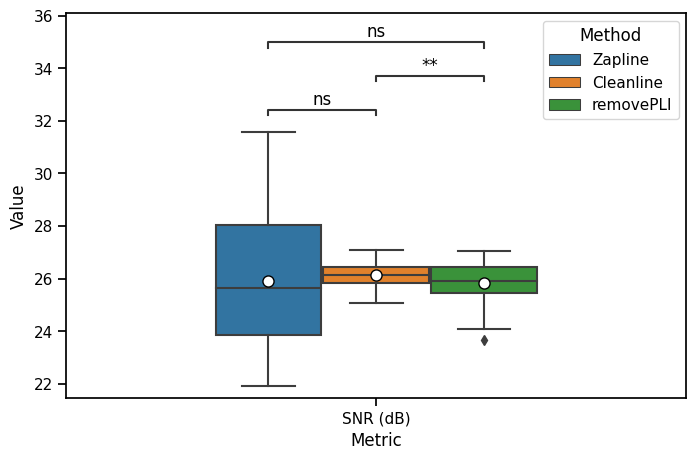

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMSE - Time Domain ($\mu$V)_Zapline vs. RMSE - Time Domain ($\mu$V)_Cleanline: Custom statistical test, P_val:1.965e-02
RMSE - Time Domain ($\mu$V)_Cleanline vs. RMSE - Time Domain ($\mu$V)_removePLI: Custom statistical test, P_val:9.000e-04
RMSE - Time Domain ($\mu$V)_Zapline vs. RMSE - Time Domain ($\mu$V)_removePLI: Custom statistical test, P_val:1.549e-01


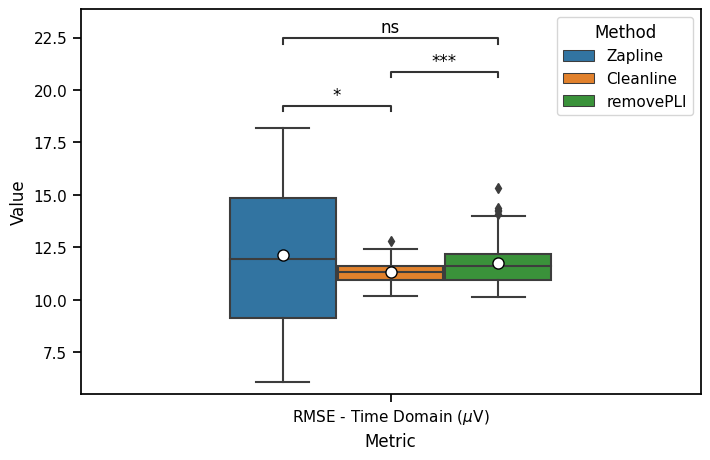

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Correlation coefficient_Zapline vs. Correlation coefficient_Cleanline: Custom statistical test, P_val:3.100e-04
Correlation coefficient_Cleanline vs. Correlation coefficient_removePLI: Custom statistical test, P_val:1.500e-05
Correlation coefficient_Zapline vs. Correlation coefficient_removePLI: Custom statistical test, P_val:1.500e-05


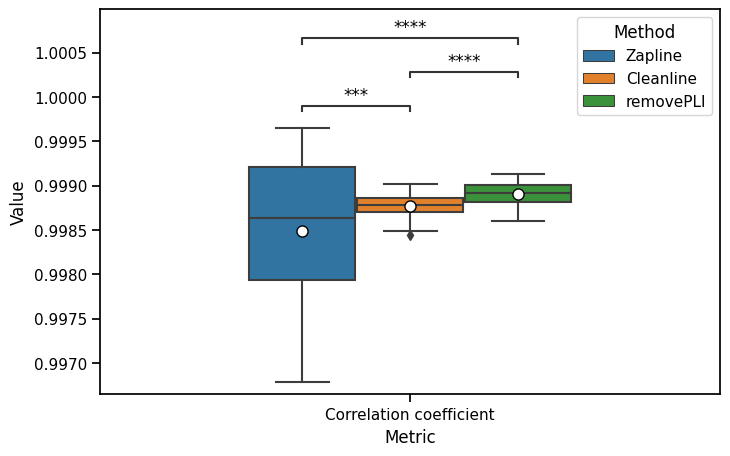

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Spectral error ($\mu$V$^2$/Hz)_Zapline vs. Spectral error ($\mu$V$^2$/Hz)_Cleanline: Custom statistical test, P_val:1.000e-05
Spectral error ($\mu$V$^2$/Hz)_Cleanline vs. Spectral error ($\mu$V$^2$/Hz)_removePLI: Custom statistical test, P_val:1.000e-05
Spectral error ($\mu$V$^2$/Hz)_Zapline vs. Spectral error ($\mu$V$^2$/Hz)_removePLI: Custom statistical test, P_val:1.000e-05


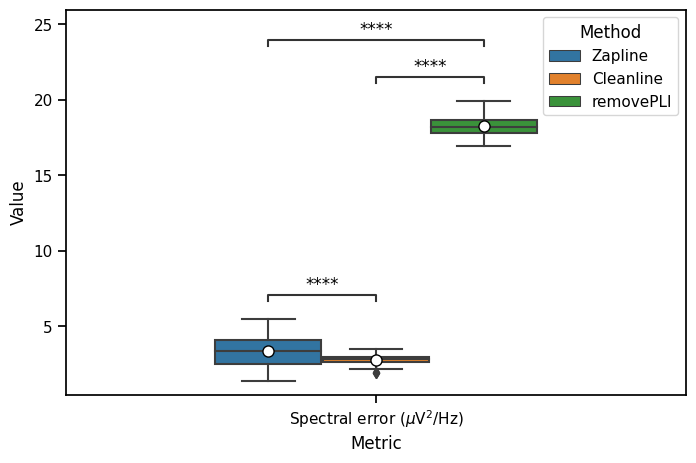

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Attenuation (dB)_Zapline vs. Attenuation (dB)_Cleanline: Custom statistical test, P_val:9.375e-03
Attenuation (dB)_Cleanline vs. Attenuation (dB)_removePLI: Custom statistical test, P_val:9.375e-03
Attenuation (dB)_Zapline vs. Attenuation (dB)_removePLI: Custom statistical test, P_val:4.813e-01


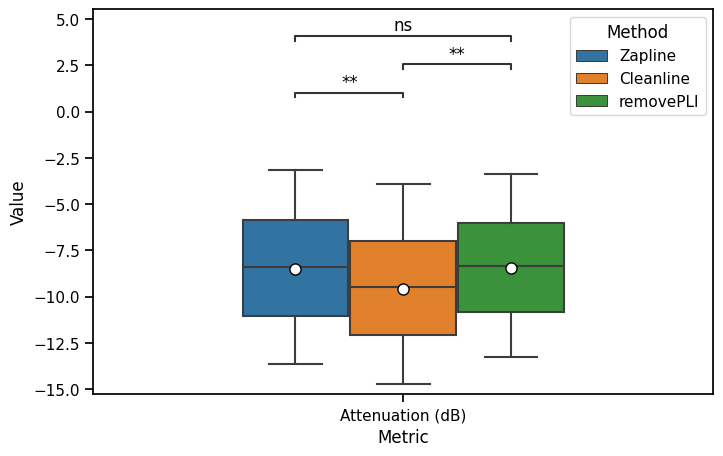

In [12]:
# Generate pairs
elements = df.Method.unique()

# Generate combinations of length 2 without repetition
combinations_without_repetition = list(combinations(elements, 2))

# Run permutation with median
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
    # return np.median(x, axis=axis) - np.median(y, axis=axis)

for metric in df.Metric.unique():
    df_tmp = df.loc[df.Metric==metric]

    pairs=[]
    p_vals = []
    for metric in df_tmp.Metric.unique():#Not necessary as we're plotting 1 metric at a time
        p_vals_tmp = []
        for element_1, element_2 in combinations_without_repetition:
            # print(f'\n Comparison between {net_1} and {net_2}\n')
            x = df_tmp.loc[(df.Metric == metric).astype(bool) & (df.Method == element_1).astype(bool),'Value'].values
            y = df_tmp.loc[(df.Metric == metric).astype(bool) & (df.Method == element_2).astype(bool),'Value'].values 
            base = statistic(x, y, 0) # Small network has worst performance
            # Permutation testing
            res = permutation_test((x, y), statistic, vectorized=True,
                               n_resamples=100000, alternative='less' if base<0 else 'greater')
            # print('Real diff',res.statistic)
            # print('p-val: ', res.pvalue)
            p_vals_tmp.append(res.pvalue)
            pairs.append([(metric, element_1), (metric, element_2)])
        # Correct them
        significance, corr_p_vals = fdrcorrection(p_vals_tmp)
        p_vals += corr_p_vals.tolist()

    # Plot params
    plotting_parameters = {
        'data': df_tmp,
        'y': "Value",
        'x': "Metric",
        'hue':'Method'
    }
    # sns.boxplot(data=df_tmp, x="Value", y="Metric", hue='Name_Net')
    with sns.plotting_context('notebook', font_scale = 1):
        # Create new plot
        ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))
        # Plot with seaborn
        ax = sns.boxplot(**plotting_parameters, showmeans=True,
                meanprops={'marker':'o',
                           'markerfacecolor':'white', 
                           'markeredgecolor':'black',
                           'markersize':'8'})

        # Add annotations
        annotator = Annotator(ax, pairs, **plotting_parameters)
        annotator.configure(text_format="star")
        annotator.set_pvalues_and_annotate(p_vals)
        # Label and show
        plt.show()

The best time performance is from Cleanline but Zapline has way better results in freq and power domain

#### Plots comparison

In [34]:
import matplotlib
matplotlib.rc_file_defaults()
font = {'size'   : 22}

matplotlib.rc('font', **font)

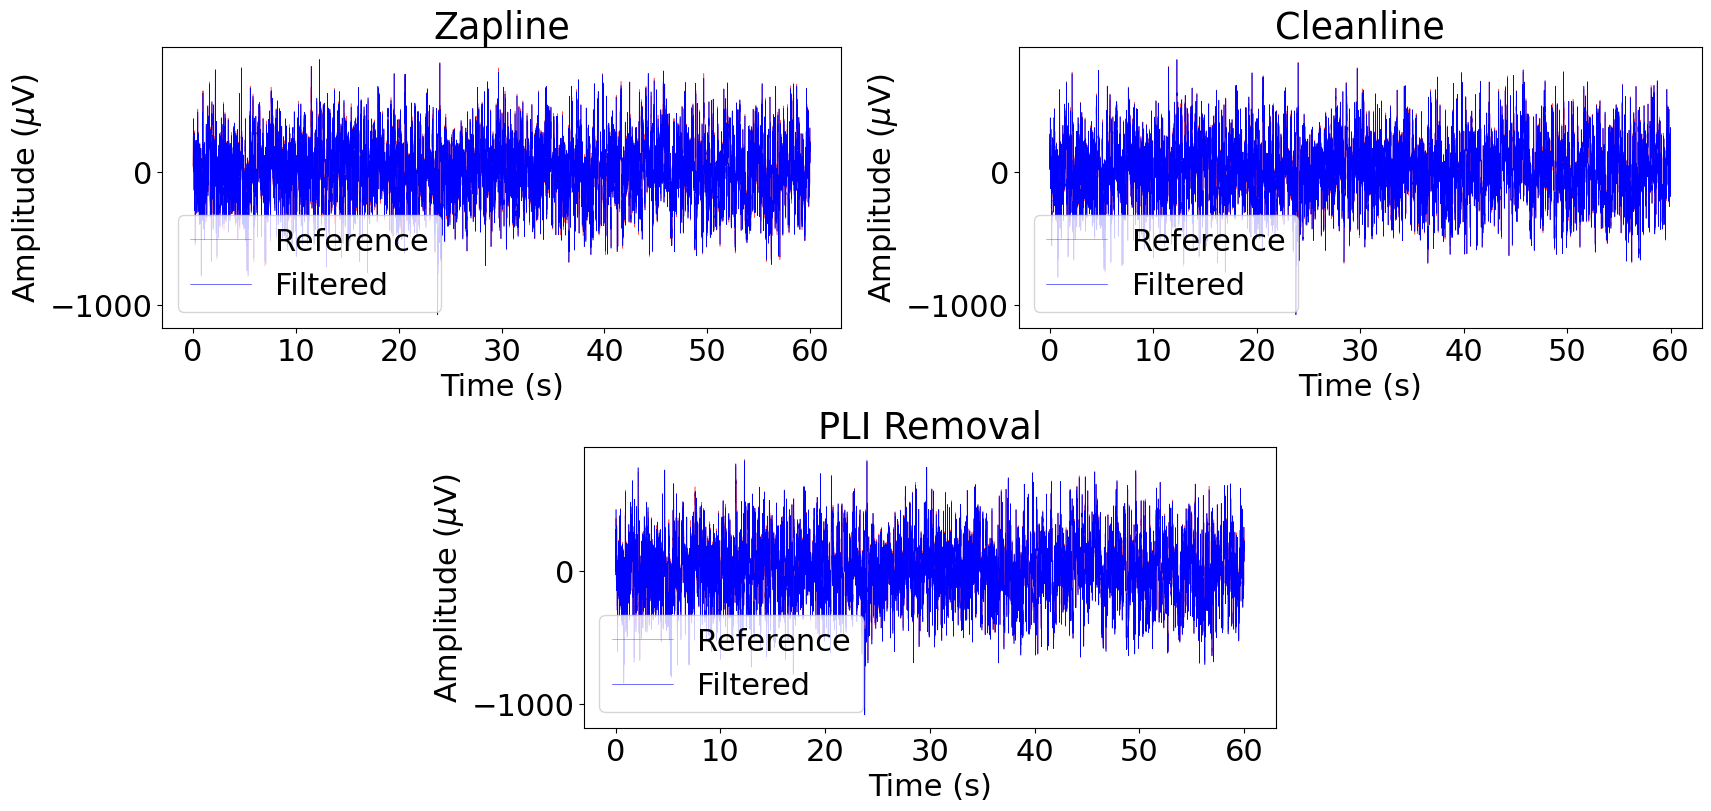

In [35]:
# Comparison against ground truth
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(17,8))
gs = fig.add_gridspec(2,4)
# gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

fs=400
time = (np.arange(0,len(s[:,0]))/fs)[:60*fs]
signal_idx = 93


ax1.plot(time, s[:60*fs,signal_idx], 'r', linewidth=0.4, alpha=0.7, label='Reference')
ax1.plot(time, y1[:60*fs,signal_idx], 'b', linewidth=0.4, label='Filtered')
ax1.set_title('Zapline')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude ($\mu$V)')
ax1.legend()

ax2.plot(time, s[:60*fs,signal_idx], 'r', linewidth=0.4, alpha=0.7, label='Reference')
ax2.plot(time, y2[:60*fs,signal_idx], 'b', linewidth=0.4, label='Filtered')
ax2.set_title('Cleanline')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude ($\mu$V)')
ax2.legend()

ax3.plot(time, s[:60*fs,signal_idx], 'r', linewidth=0.4, alpha=0.7, label='Reference')
ax3.plot(time, y3[:60*fs, signal_idx], 'b', linewidth=0.4, label='Filtered')
ax3.set_title('PLI Removal')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Amplitude ($\mu$V)')
ax3.legend()

plt.show()

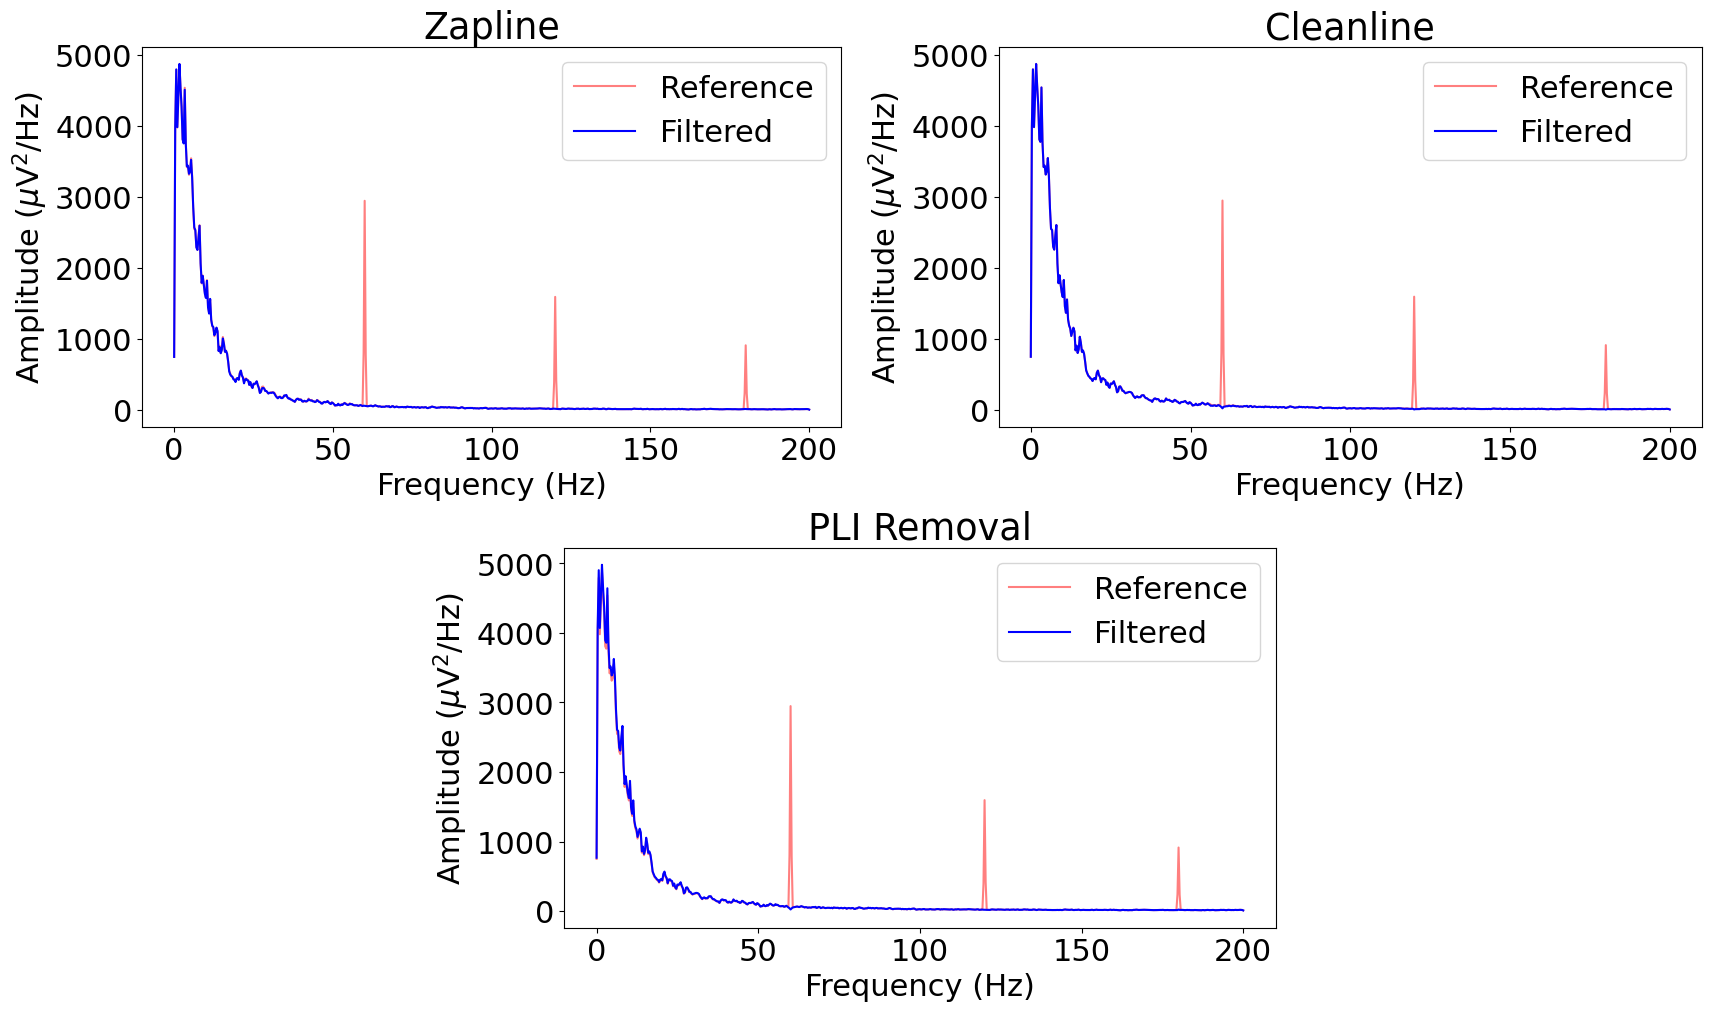

In [36]:
# Comparison against ground truth
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(17,10))
gs = fig.add_gridspec(2,4)
# gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

length_segment = 3.0
f_o, w_o = welch(eeg_signal_a[:,signal_idx], fs=fs, nperseg=int(length_segment*fs))
ax1.plot(f_o, w_o, 'r', alpha=0.5, label='Reference')
f, w = welch(y1[:,signal_idx], fs=fs, nperseg=int(length_segment*fs))
ax1.plot(f, w, 'b', label='Filtered')
ax1.set_title('Zapline')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude ($\mu$V$^2$/Hz)')
ax1.legend()

ax2.plot(f_o, w_o, 'r', alpha=0.5, label='Reference')
f, w = welch(y2[:,signal_idx], fs=fs, nperseg=int(length_segment*fs))
ax2.plot(f, w, 'b', label='Filtered')
ax2.set_title('Cleanline')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude ($\mu$V$^2$/Hz)')
ax2.legend()

ax3.plot(f_o, w_o, 'r', alpha=0.5, label='Reference')
f, w = welch(y3[:,signal_idx], fs=fs, nperseg=int(length_segment*fs))
ax3.plot(f, w, 'b', label='Filtered')
ax3.set_title('PLI Removal')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Amplitude ($\mu$V$^2$/Hz)')
ax3.legend()

plt.show()

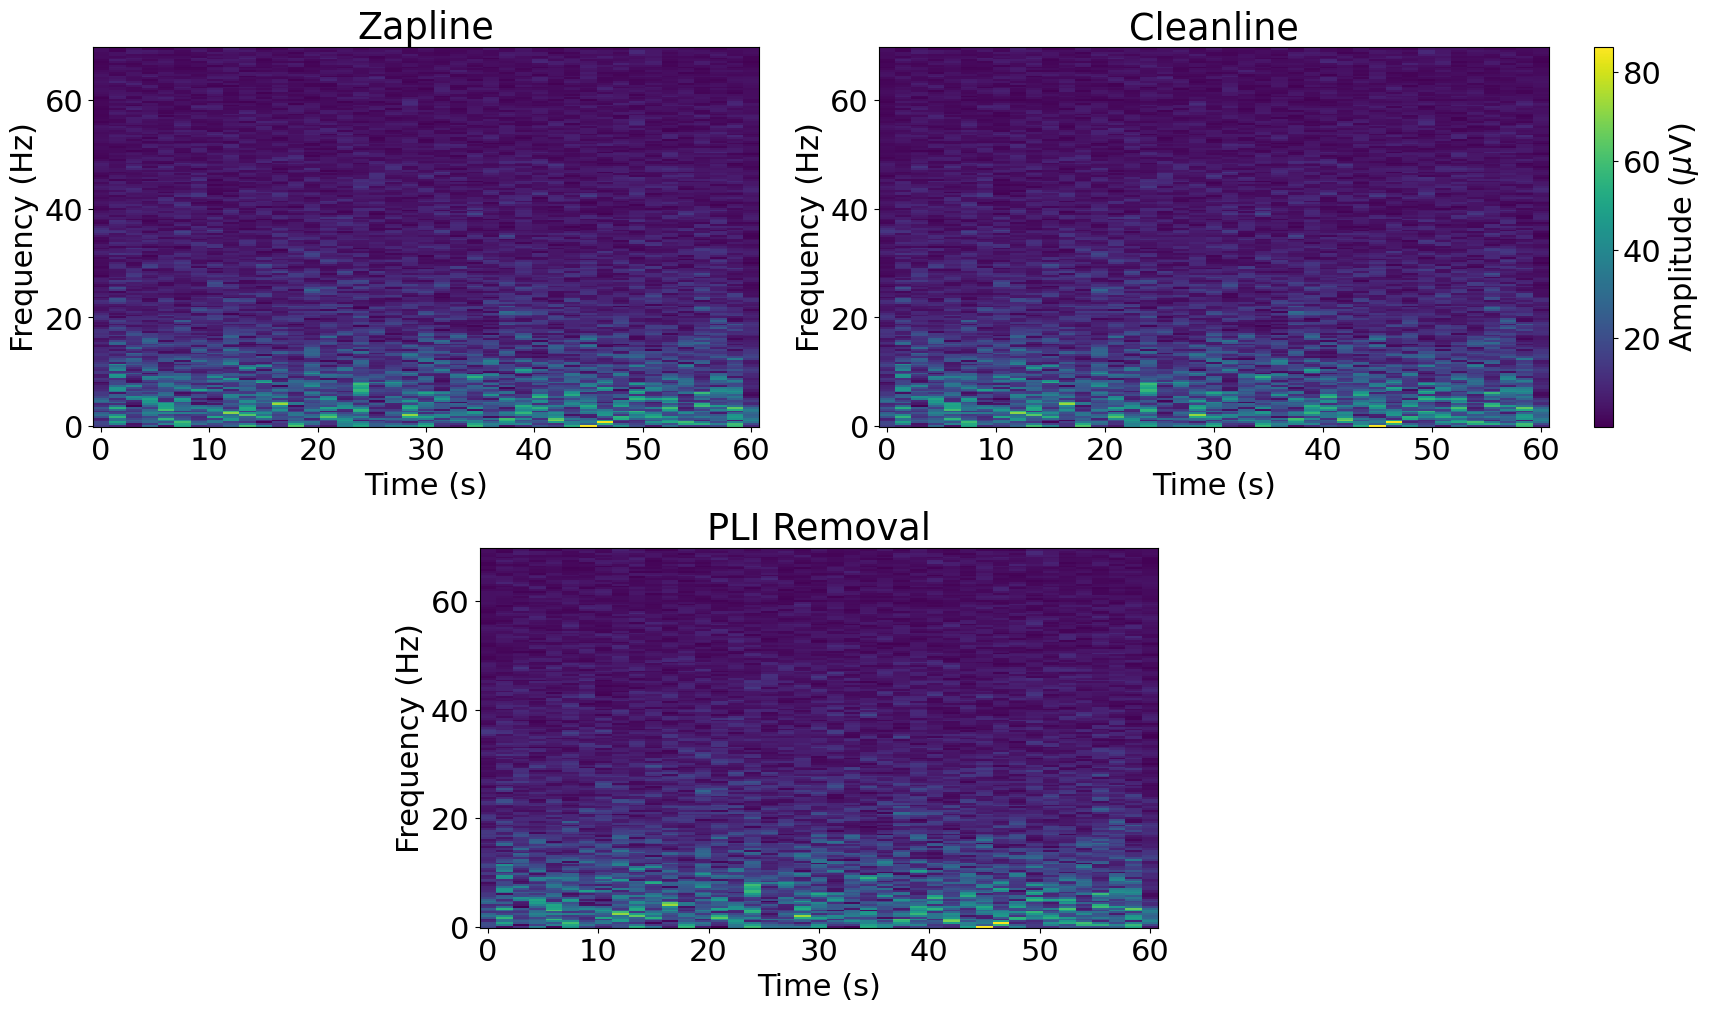

In [37]:
# Comparison against ground truth
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(17,10))
gs = fig.add_gridspec(2,4)
# gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

length_segment = 3.0
f, t, Zxx_1 = scipy.signal.stft(y1[:60*fs,signal_idx], fs=fs, nperseg=length_segment*fs)
f, t, Zxx_2 = scipy.signal.stft(y2[:60*fs,signal_idx], fs=fs, nperseg=length_segment*fs)
f, t, Zxx_3 = scipy.signal.stft(y3[:60*fs, signal_idx], fs=fs, nperseg=length_segment*fs)

# Plot between 50 and 70 Hz
f_max = np.argmin(np.abs(f-70))
f_min = np.argmin(np.abs(f-0))
Zxx_1 = Zxx_1[f_min:f_max,:]
Zxx_2 = Zxx_2[f_min:f_max,:]
Zxx_3 = Zxx_3[f_min:f_max,:]

vmin=min(np.min(np.abs(Zxx_1)), np.min(np.abs(Zxx_2)), np.min(np.abs(Zxx_3)))
vmax=min(np.max(np.abs(Zxx_1)), np.max(np.abs(Zxx_2)), np.max(np.abs(Zxx_3)))

ax1.pcolormesh(t, f[f_min:f_max], np.abs(Zxx_1), vmin=vmin, vmax=vmax)
ax1.set_title('Zapline')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Frequency (Hz)')

c = ax2.pcolormesh(t, f[f_min:f_max], np.abs(Zxx_2), vmin=vmin, vmax=vmax)
ax2.set_title('Cleanline')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
plt.colorbar(c, ax=ax2, label='Amplitude ($\mu$V)')  # Add colorbar for the last subplot

ax3.pcolormesh(t, f[f_min:f_max], np.abs(Zxx_3), vmin=vmin, vmax=vmax)
ax3.set_title('PLI Removal')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')

plt.show()

Zapline is the one that improves the best, as it was expected

### Case B

In [38]:
fs = 400

In [41]:
y2 = cleanline(eeg_signal_b, fs, bandwidth=8) # Default in app

/scratch/mcesped/code/sEEGPrep/notebooks/../clean_seeg/clean_seeg/utils.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  datafit[indx, :] = datafitwin
/scratch/mcesped/code/sEEGPrep/notebooks/../clean_seeg/clean_seeg/utils.py:848: ComplexWarning: Casting complex values to real discards the imaginary part
  datafitwin[0:Noverlap, :] = np.multiply(
/scratch/mcesped/code/sEEGPrep/notebooks/../clean_seeg/clean_seeg/utils.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  datafit[indx, :] = datafitwin
/scratch/mcesped/code/sEEGPrep/notebooks/../clean_seeg/clean_seeg/utils.py:848: ComplexWarning: Casting complex values to real discards the imaginary part
  datafitwin[0:Noverlap, :] = np.multiply(
/scratch/mcesped/code/sEEGPrep/notebooks/../clean_seeg/clean_seeg/utils.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  datafit[indx, :] = datafitwin
/scratch/mcesped/code/sEEGPrep/notebooks/..

In [42]:
y2.shape

(48000, 100)

In [43]:
y1 = zapline(eeg_signal_b, 60/fs, fs)

In [44]:
# Run removePLI for all
y3 = removePLI_chns(eeg_signal_b,
                    fs,
                    3,
                    [100, 0.01, 4],
                    [0.1, 2, 5],
                    2,
                    f_ac=60,
                    processes=4)
y3.shape

(48000, 100)

#### Metrics based on diff with ground truth

In [45]:
from utils import compute_metrics

In [46]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:3f}'.format})

In [47]:
dict_total = []
for y, method in [(y1, 'Zapline'), (y2, 'Cleanline'), (y3, 'removePLI')]:
    for ind in range(y.shape[-1]):
        metrics = compute_metrics(s[:,ind], y[:,ind], eeg_signal_a[:,ind], srate=400)
        for metric in metrics:
            metric_dict =  dict()
            metric_dict['Metric']=metric
            metric_dict['Value']=metrics[metric]
            metric_dict['chn']=ind
            metric_dict['Method']=method
            dict_total.append(metric_dict)

In [48]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import permutation_test
from itertools import combinations
from statsmodels.stats.multitest import fdrcorrection
from statannotations.Annotator import Annotator

In [49]:
df = pd.DataFrame(dict_total)
df.tail()

,Metric,Value,chn,Method
1495,SNR (dB),9.457735,99,removePLI
1496,RMSE - Time Domain ($\mu$V),77.678492,99,removePLI
1497,Correlation coefficient,0.949032,99,removePLI
1498,Spectral error ($\mu$V$^2$/Hz),189.062057,99,removePLI
1499,Attenuation (dB),5.221200,99,removePLI


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SNR (dB)_Zapline vs. SNR (dB)_Cleanline: Custom statistical test, P_val:1.500e-05
SNR (dB)_Cleanline vs. SNR (dB)_removePLI: Custom statistical test, P_val:6.384e-02
SNR (dB)_Zapline vs. SNR (dB)_removePLI: Custom statistical test, P_val:1.500e-05


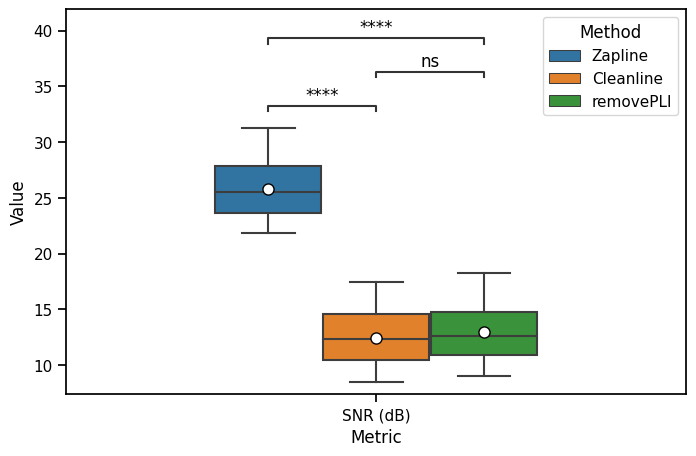

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMSE - Time Domain ($\mu$V)_Zapline vs. RMSE - Time Domain ($\mu$V)_Cleanline: Custom statistical test, P_val:1.500e-05
RMSE - Time Domain ($\mu$V)_Cleanline vs. RMSE - Time Domain ($\mu$V)_removePLI: Custom statistical test, P_val:5.703e-02
RMSE - Time Domain ($\mu$V)_Zapline vs. RMSE - Time Domain ($\mu$V)_removePLI: Custom statistical test, P_val:1.500e-05


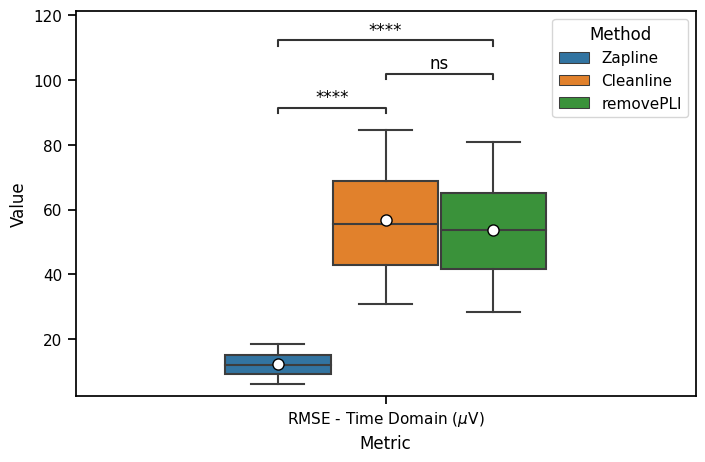

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Correlation coefficient_Zapline vs. Correlation coefficient_Cleanline: Custom statistical test, P_val:1.500e-05
Correlation coefficient_Cleanline vs. Correlation coefficient_removePLI: Custom statistical test, P_val:2.079e-02
Correlation coefficient_Zapline vs. Correlation coefficient_removePLI: Custom statistical test, P_val:1.500e-05


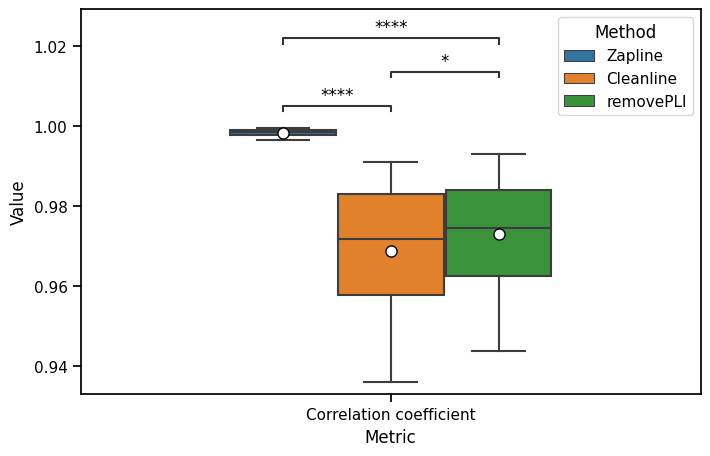

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Spectral error ($\mu$V$^2$/Hz)_Zapline vs. Spectral error ($\mu$V$^2$/Hz)_Cleanline: Custom statistical test, P_val:1.500e-05
Spectral error ($\mu$V$^2$/Hz)_Cleanline vs. Spectral error ($\mu$V$^2$/Hz)_removePLI: Custom statistical test, P_val:9.190e-03
Spectral error ($\mu$V$^2$/Hz)_Zapline vs. Spectral error ($\mu$V$^2$/Hz)_removePLI: Custom statistical test, P_val:1.500e-05


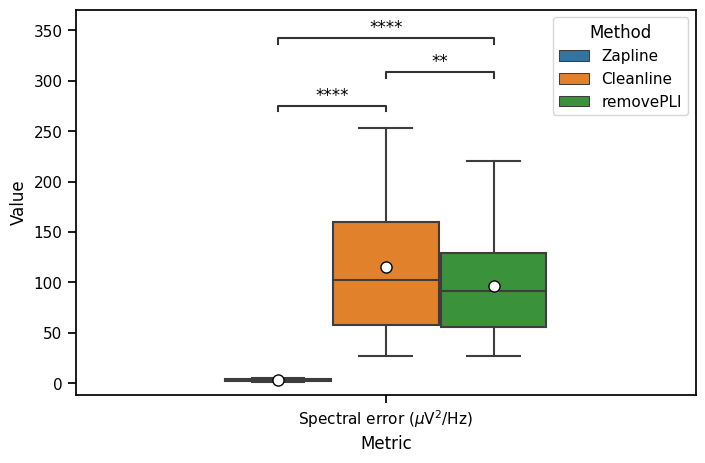

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Attenuation (dB)_Zapline vs. Attenuation (dB)_Cleanline: Custom statistical test, P_val:1.500e-05
Attenuation (dB)_Cleanline vs. Attenuation (dB)_removePLI: Custom statistical test, P_val:1.840e-01
Attenuation (dB)_Zapline vs. Attenuation (dB)_removePLI: Custom statistical test, P_val:1.500e-05


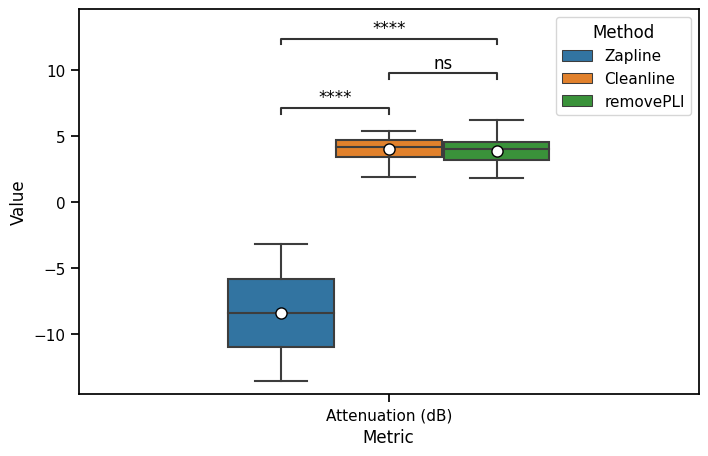

In [50]:
# Generate pairs
elements = df.Method.unique()

# Generate combinations of length 2 without repetition
combinations_without_repetition = list(combinations(elements, 2))

# Run permutation with median
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
    # return np.median(x, axis=axis) - np.median(y, axis=axis)

for metric in df.Metric.unique():
    df_tmp = df.loc[df.Metric==metric]

    pairs=[]
    p_vals = []
    for metric in df_tmp.Metric.unique():
        p_vals_tmp = []
        for element_1, element_2 in combinations_without_repetition:
            # print(f'\n Comparison between {net_1} and {net_2}\n')
            x = df_tmp.loc[(df.Metric == metric).astype(bool) & (df.Method == element_1).astype(bool),'Value'].values
            y = df_tmp.loc[(df.Metric == metric).astype(bool) & (df.Method == element_2).astype(bool),'Value'].values 
            base = statistic(x, y, 0) # Small network has worst performance
            # Permutation testing
            res = permutation_test((x, y), statistic, vectorized=True,
                               n_resamples=100000, alternative='less' if base<0 else 'greater')
            # print('Real diff',res.statistic)
            # print('p-val: ', res.pvalue)
            p_vals_tmp.append(res.pvalue)
            pairs.append([(metric, element_1), (metric, element_2)])
        # Correct them
        significance, corr_p_vals = fdrcorrection(p_vals_tmp)
        p_vals += corr_p_vals.tolist()

    # Plot params
    plotting_parameters = {
        'data': df_tmp,
        'y': "Value",
        'x': "Metric",
        'hue':'Method'
    }
    # sns.boxplot(data=df_tmp, x="Value", y="Metric", hue='Name_Net')
    with sns.plotting_context('notebook', font_scale = 1):
        # Create new plot
        ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))
        # Plot with seaborn
        ax = sns.boxplot(**plotting_parameters, showmeans=True,
                meanprops={'marker':'o',
                           'markerfacecolor':'white', 
                           'markeredgecolor':'black',
                           'markersize':'8'})

        # Add annotations
        annotator = Annotator(ax, pairs, **plotting_parameters)
        annotator.configure(text_format="star")
        annotator.set_pvalues_and_annotate(p_vals)
        # Label and show
        plt.show()

The best time performance is from Cleanline but Zapline has way better results in freq and power domain

#### Plots comparison

In [51]:
import matplotlib
matplotlib.rc_file_defaults()
font = {'size'   : 22}

matplotlib.rc('font', **font)

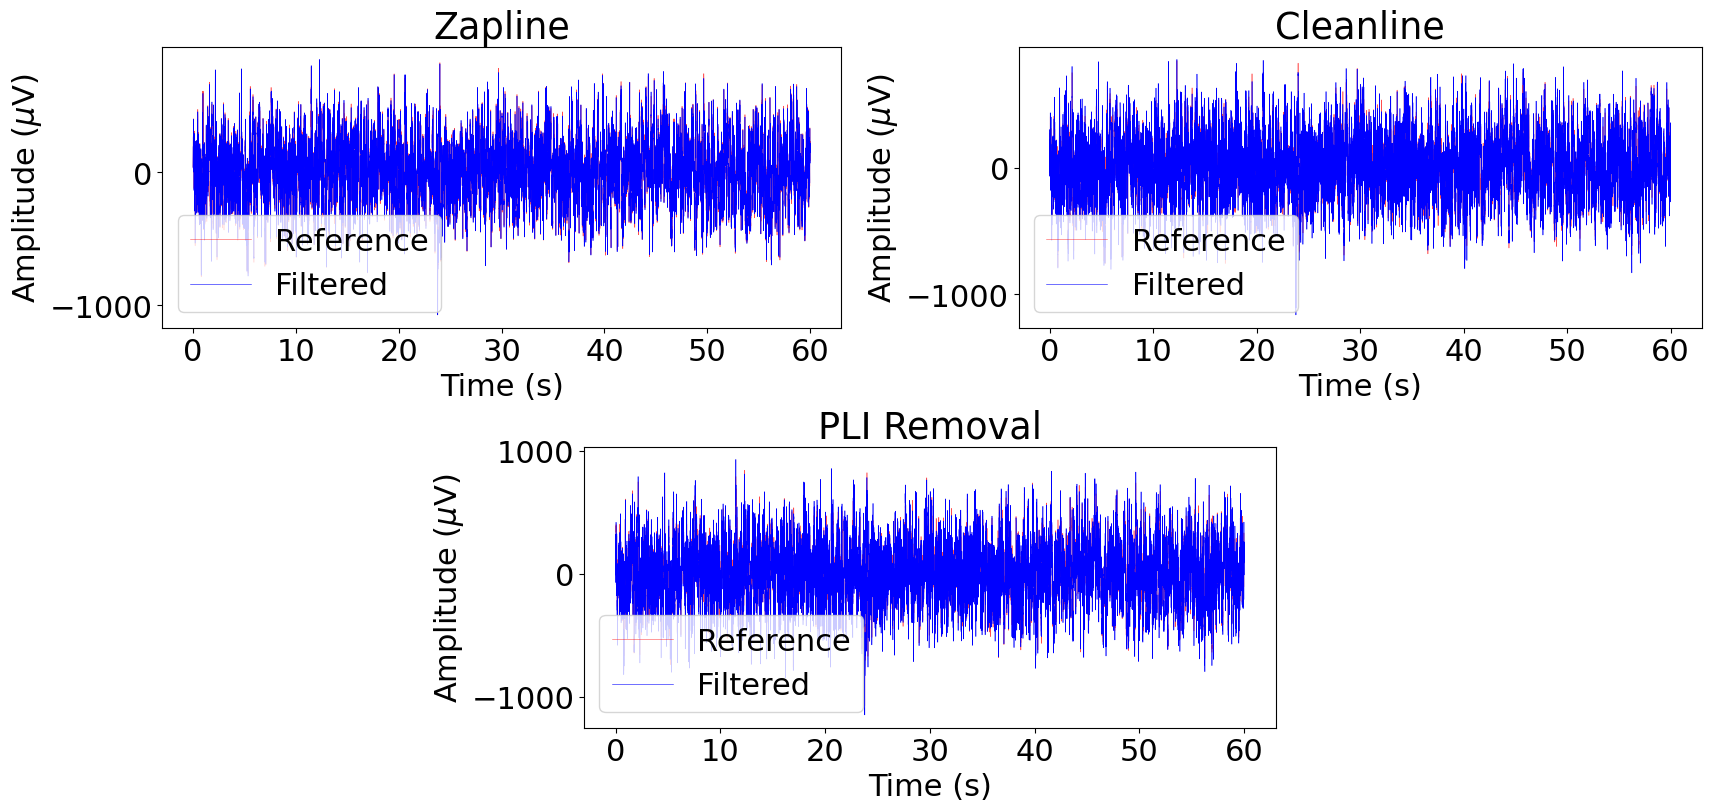

In [54]:
# Comparison against ground truth
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(17,8))
gs = fig.add_gridspec(2,4)
# gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

time = (np.arange(0,len(s[:,0]))/fs)[:60*fs]
signal_idx = 93

ax1.plot(time, s[:60*fs,signal_idx], 'r', linewidth=0.4, alpha=0.7, label='Reference')
ax1.plot(time, y1[:60*fs,signal_idx], 'b', linewidth=0.4, label='Filtered')
ax1.set_title('Zapline')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude ($\mu$V)')
ax1.legend()

ax2.plot(time, s[:60*fs,signal_idx], 'r', linewidth=0.4, alpha=0.7, label='Reference')
ax2.plot(time, y2[:60*fs,signal_idx], 'b', linewidth=0.4, label='Filtered')
ax2.set_title('Cleanline')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude ($\mu$V)')
ax2.legend()

ax3.plot(time, s[:60*fs,signal_idx], 'r', linewidth=0.4, alpha=0.7, label='Reference')
ax3.plot(time, y3[:60*fs, signal_idx], 'b', linewidth=0.4, label='Filtered')
ax3.set_title('PLI Removal')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Amplitude ($\mu$V)')
ax3.legend()

plt.show()

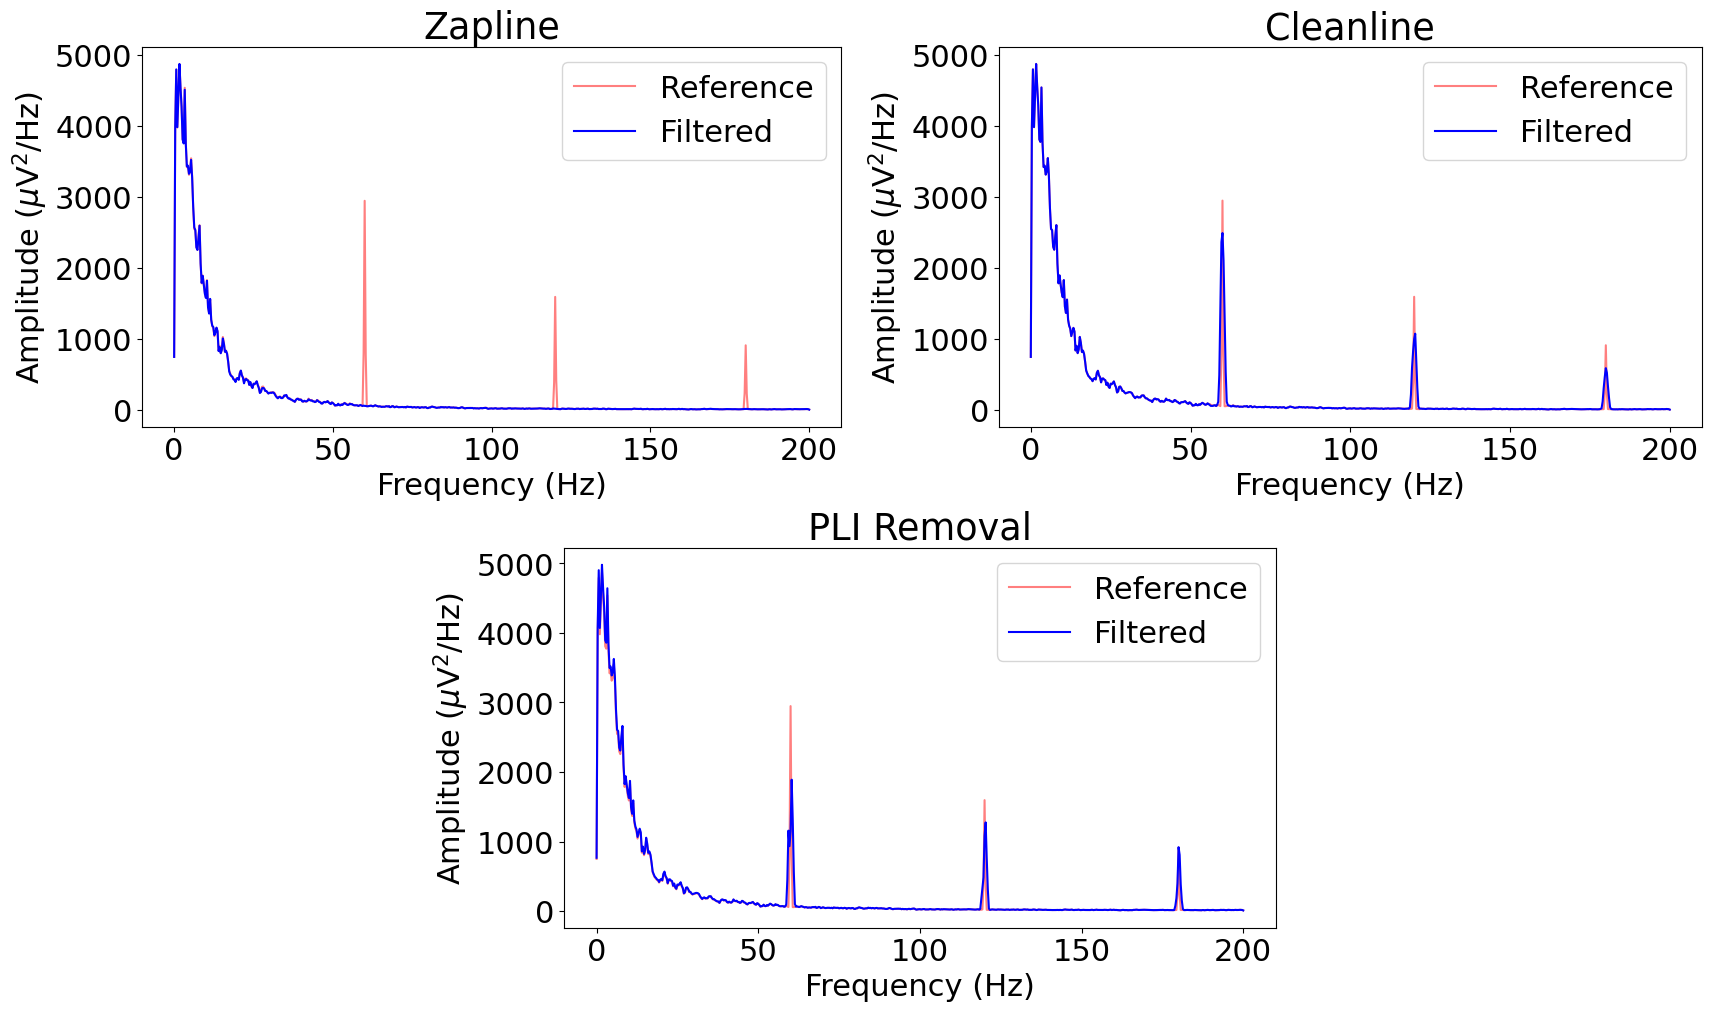

In [55]:
# Comparison against ground truth
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(17,10))
gs = fig.add_gridspec(2,4)
# gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

length_segment = 3.0
f_o, w_o = welch(eeg_signal_a[:,signal_idx], fs=fs, nperseg=int(length_segment*fs))
ax1.plot(f_o, w_o, 'r', alpha=0.5, label='Reference')
f, w = welch(y1[:,signal_idx], fs=fs, nperseg=int(length_segment*fs))
ax1.plot(f, w, 'b', label='Filtered')
ax1.set_title('Zapline')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude ($\mu$V$^2$/Hz)')
ax1.legend()

ax2.plot(f_o, w_o, 'r', alpha=0.5, label='Reference')
f, w = welch(y2[:,signal_idx], fs=fs, nperseg=int(length_segment*fs))
ax2.plot(f, w, 'b', label='Filtered')
ax2.set_title('Cleanline')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude ($\mu$V$^2$/Hz)')
ax2.legend()

ax3.plot(f_o, w_o, 'r', alpha=0.5, label='Reference')
f, w = welch(y3[:,signal_idx], fs=fs, nperseg=int(length_segment*fs))
ax3.plot(f, w, 'b', label='Filtered')
ax3.set_title('PLI Removal')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Amplitude ($\mu$V$^2$/Hz)')
ax3.legend()

plt.show()

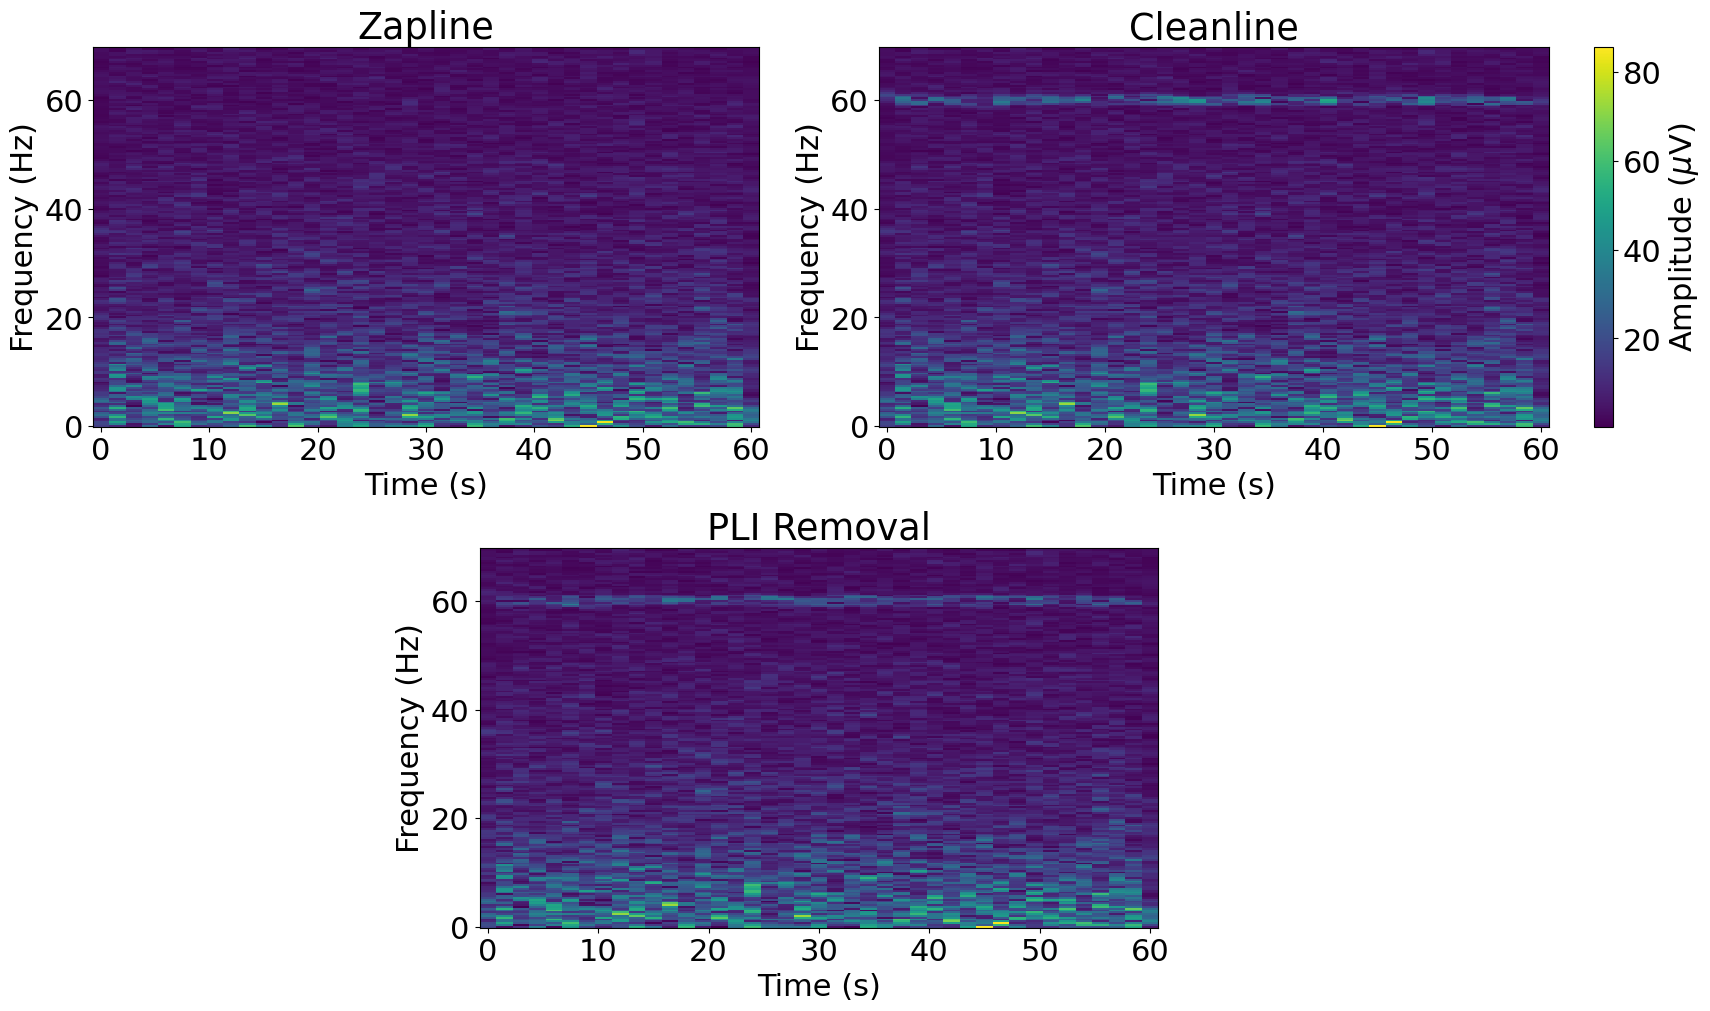

In [56]:
# Comparison against ground truth
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(17,10))
gs = fig.add_gridspec(2,4)
# gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

length_segment = 3.0
f, t, Zxx_1 = scipy.signal.stft(y1[:60*fs,signal_idx], fs=fs, nperseg=length_segment*fs)
f, t, Zxx_2 = scipy.signal.stft(y2[:60*fs,signal_idx], fs=fs, nperseg=length_segment*fs)
f, t, Zxx_3 = scipy.signal.stft(y3[:60*fs, signal_idx], fs=fs, nperseg=length_segment*fs)

# Plot between 50 and 70 Hz
f_max = np.argmin(np.abs(f-70))
f_min = np.argmin(np.abs(f-0))
Zxx_1 = Zxx_1[f_min:f_max,:]
Zxx_2 = Zxx_2[f_min:f_max,:]
Zxx_3 = Zxx_3[f_min:f_max,:]

vmin=min(np.min(np.abs(Zxx_1)), np.min(np.abs(Zxx_2)), np.min(np.abs(Zxx_3)))
vmax=min(np.max(np.abs(Zxx_1)), np.max(np.abs(Zxx_2)), np.max(np.abs(Zxx_3)))

ax1.pcolormesh(t, f[f_min:f_max], np.abs(Zxx_1), vmin=vmin, vmax=vmax)
ax1.set_title('Zapline')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Frequency (Hz)')

c3 = ax2.pcolormesh(t, f[f_min:f_max], np.abs(Zxx_2), vmin=vmin, vmax=vmax)
ax2.set_title('Cleanline')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')

ax3.pcolormesh(t, f[f_min:f_max], np.abs(Zxx_3), vmin=vmin, vmax=vmax)
ax3.set_title('PLI Removal')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
plt.colorbar(c3, ax=ax2, label='Amplitude ($\mu$V)')  # Add colorbar for the last subplot

plt.show()

## Test real signal

In [58]:
# Cleanline
import pyedflib
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-PLI_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx = edf_epoch.getSignalLabels().index('LPIn2-3')
    y2 = edf_epoch.readSignal(idx)

In [59]:
# Zapline
import pyedflib
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-Zapline_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx = edf_epoch.getSignalLabels().index('LPIn2-3')
    y1 = edf_epoch.readSignal(idx)

In [60]:
# removePLI
import pyedflib
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-PLIremoval_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx = edf_epoch.getSignalLabels().index('LPIn2-3')
    y3 = edf_epoch.readSignal(idx)

#### Plots comparison

In [61]:
import matplotlib
matplotlib.rc_file_defaults()
font = {'size'   : 22}

matplotlib.rc('font', **font)

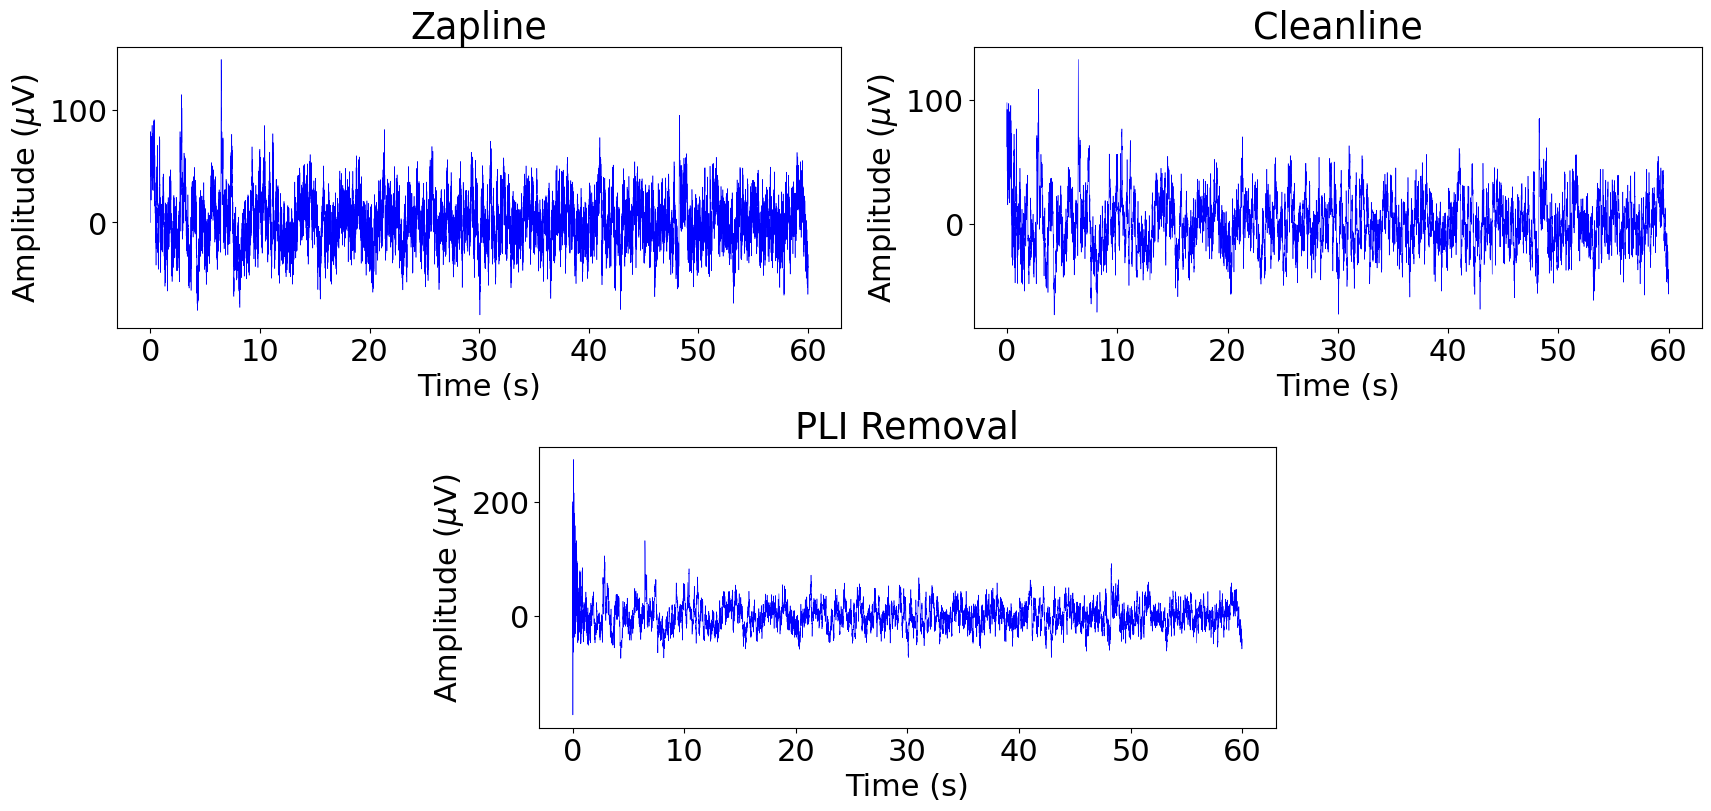

In [62]:
# Comparison against ground truth
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(17,8))
gs = fig.add_gridspec(2,4)
# gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

fs=200

time = (np.arange(0,len(s[:,0]))/fs)[:60*fs]

ax1.plot(time, y1[:60*fs], 'b', linewidth=0.4)
ax1.set_title('Zapline')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude ($\mu$V)')

ax2.plot(time, y2[:60*fs], 'b', linewidth=0.4)
ax2.set_title('Cleanline')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude ($\mu$V)')

ax3.plot(time, y3[:60*fs], 'b', linewidth=0.4)
ax3.set_title('PLI Removal')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Amplitude ($\mu$V)')

plt.show()

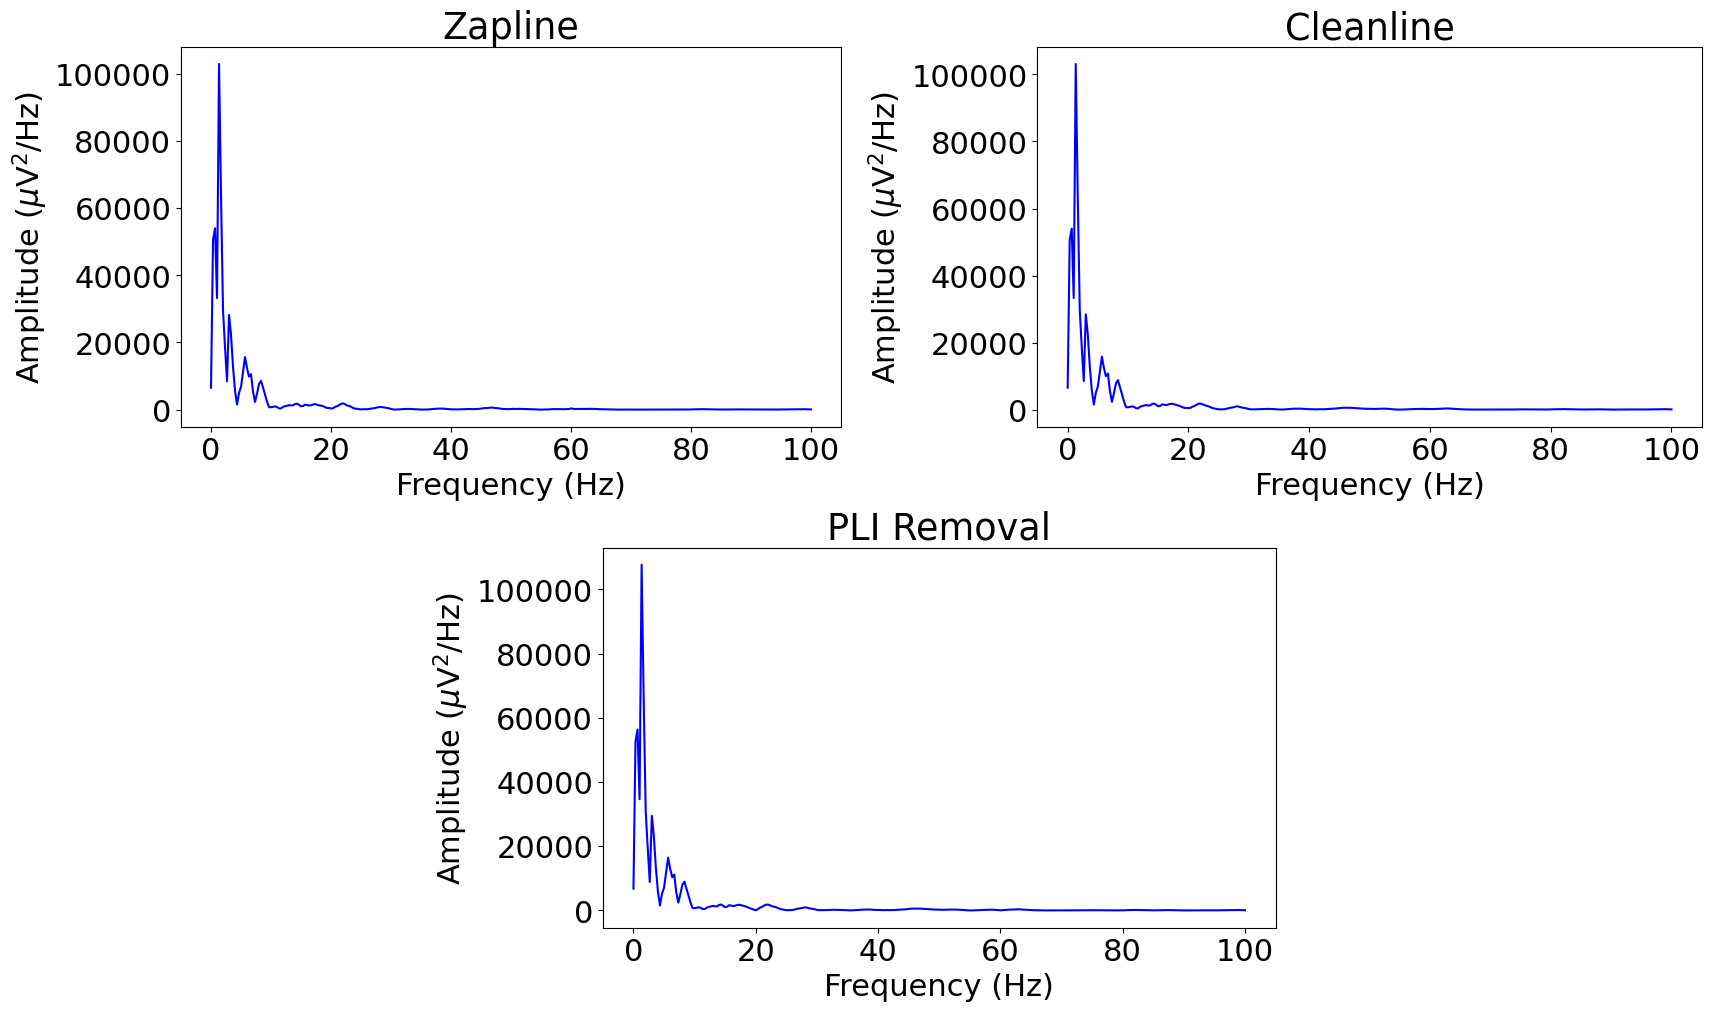

In [63]:
# Comparison against ground truth
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(17,10))
gs = fig.add_gridspec(2,4)
# gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

length_segment = 3.0

f, w = welch(y1, fs=fs, nperseg=int(length_segment*fs))
ax1.plot(f, w, 'b')
ax1.set_title('Zapline')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude ($\mu$V$^2$/Hz)')

f, w = welch(y2, fs=fs, nperseg=int(length_segment*fs))
ax2.plot(f, w, 'b')
ax2.set_title('Cleanline')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude ($\mu$V$^2$/Hz)')

f, w = welch(y3, fs=fs, nperseg=int(length_segment*fs))
ax3.plot(f, w, 'b')
ax3.set_title('PLI Removal')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Amplitude ($\mu$V$^2$/Hz)')

plt.show()

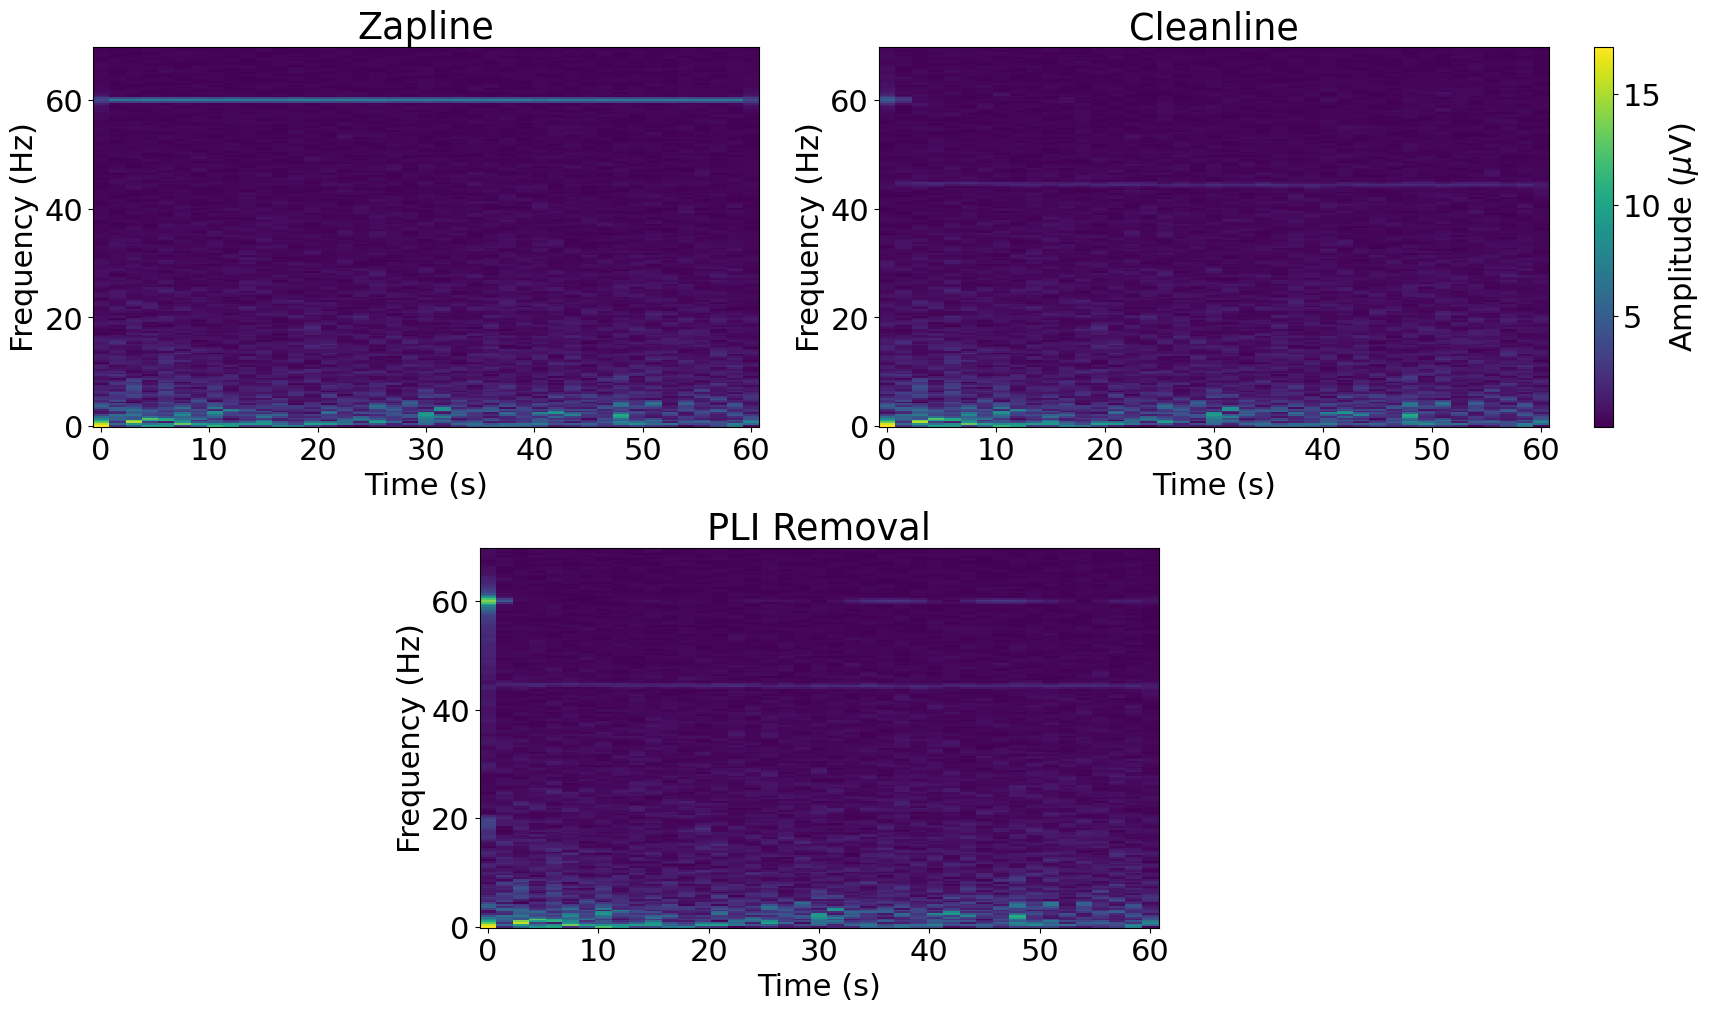

In [64]:
# Comparison against ground truth
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(17,10))
gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1])  # Adjust width ratios if needed
# gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

length_segment = 3.0
f, t, Zxx_1 = scipy.signal.stft(y1[:60*fs], fs=fs, nperseg=length_segment*fs)
f, t, Zxx_2 = scipy.signal.stft(y2[:60*fs], fs=fs, nperseg=length_segment*fs)
f, t, Zxx_3 = scipy.signal.stft(y3[:60*fs], fs=fs, nperseg=length_segment*fs)

# Plot between 50 and 70 Hz
f_max = np.argmin(np.abs(f-70))
f_min = np.argmin(np.abs(f-0))
Zxx_1 = Zxx_1[f_min:f_max,:]
Zxx_2 = Zxx_2[f_min:f_max,:]
Zxx_3 = Zxx_3[f_min:f_max,:]

vmin=min(np.min(np.abs(Zxx_1)), np.min(np.abs(Zxx_2)), np.min(np.abs(Zxx_3)))
vmax=min(np.max(np.abs(Zxx_1)), np.max(np.abs(Zxx_2)), np.max(np.abs(Zxx_3)))

ax1.pcolormesh(t, f[f_min:f_max], np.abs(Zxx_1), vmin=vmin, vmax=vmax)
ax1.set_title('Zapline')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Frequency (Hz)')

ax2.pcolormesh(t, f[f_min:f_max], np.abs(Zxx_2), vmin=vmin, vmax=vmax)
ax2.set_title('Cleanline')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')

c3 = ax3.pcolormesh(t, f[f_min:f_max], np.abs(Zxx_3), vmin=vmin, vmax=vmax)
ax3.set_title('PLI Removal')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
plt.colorbar(c3, ax=ax2, label='Amplitude ($\mu$V)')  # Add colorbar for the last subplot
# plt.colorbar(c3, ax=ax3, label='Amplitude ($\mu$V)')  # Add colorbar for the last subplot


# plt.tight_layout()
plt.show()